Qiskitでは
\begin{align}
&R_X(\theta)=e^{-i(\theta/2)X}=\cos(\theta/2)I-i\sin(\theta/2)X=
\left[
\begin{array}{cc}
\cos(\theta/2) &-i\sin(\theta/2)  \\
-i\sin(\theta/2) & \cos(\theta/2)
\end{array}
\right]\notag\\
&R_Y(\theta)=e^{-i(\theta/2)Y}=\cos(\theta/2)I-i\sin(\theta/2)Y=
\left[
\begin{array}{cc}
\cos(\theta/2) &-\sin(\theta/2)  \\
\sin(\theta/2) & \cos(\theta/2)
\end{array}
\right]\notag\\
\end{align}
である。$R_z(\theta)$に関しては理論上は
\begin{align}
&R_Z(\theta)=e^{-i(\theta/2)Z}=\cos(\theta/2)I-i\sin(\theta/2)Z=\left[
\begin{array}{cc}
e^{-i\theta/2} &0  \\
0 & e^{i\theta/2}
\end{array}
\right]=
e^{-i\theta/2}\left[
\begin{array}{cc}
1 &0  \\
0 & e^{i\theta}
\end{array}
\right]
\end{align}
であるが、Qiskitでは絶対位相を無視して
\begin{equation}
R_z(\theta)=\left[
\begin{array}{cc}
1 &0  \\
0 & e^{i\theta}
\end{array}
\right]
\end{equation}
としている。

In [1]:
!pip install qiskit

     |████████████████████████████████| 6.7MB 2.5MB/s 
     |████████████████████████████████| 23.3MB 1.5MB/s 
     |████████████████████████████████| 163kB 42.7MB/s 
     |████████████████████████████████| 174kB 50.0MB/s 
     |████████████████████████████████| 1.9MB 35.4MB/s 
     |████████████████████████████████| 768kB 43.0MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 5.8MB 44.8MB/s 
     |████████████████████████████████| 296kB 45.8MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 573kB 41.4MB/s 
     |████████████████████████████████| 26.0MB 122kB/s 
     |████████████████████████████████| 2.7MB 48.6MB/s 
  Created wheel for qiskit: filename=qiskit-0.19.3-cp36-none-any.whl size=2899 sha256=26f99fa280823b063d68763871c87311b395dd89c7d97e3169a2b63d0ad1bbcc
  Stored in directory: /root/.cache/pip/wheels/6d/48/7e/b22ec709562f69ee

In [0]:
from functools import reduce
import numpy as np
from numpy.linalg import matrix_power, eig
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.circuit.library.standard_gates import *
from qiskit.quantum_info import Pauli,Operator

In [0]:
def hamiltonian_eff():
    n_qubits = 2
    g_list = [0.3593, 0.0896, -0.4826, 0.0896]
    pauli_strings = ['ZI', 'YY', 'IZ', 'XX']
    hamiltonian_matrix = np.zeros((2**n_qubits,2**n_qubits),dtype="complex128")
    for g, h in zip(g_list, pauli_strings):
        hamiltonian_matrix += g * Pauli(label=h).to_matrix()
    vals, vecs = eigsh(hamiltonian_matrix, k=1, which='SA')
    return hamiltonian_matrix, vals

In [10]:
_, eigs = hamiltonian_eff()
exact_eigenvalue = eigs[0]
print('exact_eigenvalue: {:.10f} Ha'.format(exact_eigenvalue))

exact_eigenvalue: -0.8607602744 Ha


In [0]:
def order_n_trotter_approx(t, n_trotter_steps):
    n_qubits = 2
    g_list = [0.3593, 0.0896, -0.4826, 0.0896]
    pauli_strings = ['ZI', 'YY', 'IZ', 'XX']
    terms = []
    for g, h in zip(g_list, pauli_strings):
        arg = g * t / n_trotter_steps
        qop = complex(np.cos(arg), 0) * Pauli(label="II").to_matrix()- complex(0, np.sin(arg)) * Pauli(label=h).to_matrix()
        terms += [qop]
    sparse_matrix = reduce(np.dot, terms)
    matrix = matrix_power(sparse_matrix, n_trotter_steps)
    vals, vecs = eig(matrix)
    args = np.angle(vals)
    return sparse_matrix, sorted(args)

In [12]:
tau = 0.640
print('N, E_trot, |exact_eig - E_trot|')
for n in range(1, 10, 2):
    _, phases = order_n_trotter_approx(tau, n)
    e_trotter = phases[0]/tau
    print( f"{n}, {e_trotter:.10f}, {abs(exact_eigenvalue - e_trotter):.3e}" )

N, E_trot, |exact_eig - E_trot|
1, -0.8602760326, 4.842e-04
3, -0.8607068561, 5.342e-05
5, -0.8607410548, 1.922e-05
7, -0.8607504700, 9.804e-06
9, -0.8607543437, 5.931e-06


In [0]:
def IQPE_circuit(circuit, g_list, tau, kickback_phase, k, n_trotter_step=1):
    n_qubits = 3
    a_idx = 2
    phi = -(tau / n_trotter_step) * g_list
    circuit.h(a_idx)
    circuit.rz(-kickback_phase, a_idx)

#    G=[[RZGate(-phi[0]),XGate().control(1),RZGate(phi[0]),XGate().control(1)],
#        [SdgGate(),SdgGate(),HGate(),HGate(),XGate().control(1),RZGate(-phi[1]),XGate().control(1),RZGate(phi[1]),XGate().control(1),XGate().control(1),HGate(),HGate(),SGate(),SGate()],
#        [RZGate(-phi[2]),XGate().control(1),RZGate(phi[2]),XGate().control(1)],
#        [HGate(),HGate(),XGate().control(1),RZGate(-phi[3]),XGate().control(1),RZGate(phi[3]),XGate().control(1),XGate().control(1),HGate(),HGate()]]
#    ind=[[  [0],[a_idx,0],[0],[a_idx,0]  ],
#         [ [0],[1],[0],[1],[0,1],[1],[a_idx,1],[1],[a_idx,1],[0,1],[0],[1],[0],[1]  ],
#         [ [1],[a_idx,1],[1],[a_idx,1]  ],
#         [ [0],[1],[0,1],[1],[a_idx,1],[1],[a_idx,1],[0,1],[0],[1]  ]]

#    for _ in range( 2 ** (k-1) ):
#        for _ in range(n_trotter_step):
#            for i in range(4):
#                for j in range(len(G[i])):
#                    circuit.append(G[i][j],ind[i][j])
    for _ in range( 2 ** (k-1) ):
        for _ in range(n_trotter_step):
            # CU(Z0) i.e. controlled exp(i phi[0]*Z_0)
            circuit.rz(-phi[0],0) 
            circuit.cx(a_idx, 0)
            circuit.rz(phi[0],0)
            circuit.cx(a_idx, 0)

            # CU(Y0 Y1)
            circuit.sdg(0)
            circuit.sdg(1)
            circuit.h(0)
            circuit.h(1)
            circuit.cx(0, 1)
            circuit.rz(-phi[1],1)
            circuit.cx(a_idx, 1)
            circuit.rz(phi[1],1)
            circuit.cx(a_idx, 1)
            circuit.cx(0, 1)
            circuit.h(0)
            circuit.h(1)
            circuit.s(0)
            circuit.s(1)

            # CU(Z1)
            circuit.rz(-phi[2],1)
            circuit.cx(a_idx, 1)
            circuit.rz(phi[2],1)
            circuit.cx(a_idx, 1)

            # CU(X0 X1)
            circuit.h(0)
            circuit.h(1)
            circuit.cx(0, 1)
            circuit.rz(-phi[3],1)
            circuit.cx(a_idx, 1)
            circuit.rz(phi[3],1)
            circuit.cx(a_idx, 1)
            circuit.cx(0, 1)
            circuit.h(0)
            circuit.h(1)
            
    circuit.h(a_idx)
    return circuit

def meas_operator(n_qubits,a_idx,bit):
    meas = np.array([[(1+bit)%2,0],[0,(0+bit)%2]])
    if a_idx==0:
        M=meas
    else:
        M=np.eye(2)
    for i in range(1,n_qubits):
        if i==a_idx:
            M=np.kron(meas,M) 
        else:
            M=np.kron(np.eye(2),M)         
    return M
        
def iterative_phase_estimation( g_list, tau, n_itter, n_trotter_step=1, kickback_phase=0.0):
    #a_idx=2
    for k in reversed(range(1, n_itter+1)):
        qc = QuantumCircuit(n_qubits)
        qc.x(0)
        qc = IQPE_circuit(qc,np.array(g_list), tau, kickback_phase, k, n_trotter_step=n_trotter_step)
        state=execute(qc,Aer.get_backend("statevector_simulator")).result().get_statevector()
        meas_0=meas_operator(n_qubits,2,0)
        meas_1=meas_operator(n_qubits,2,1)
        p0 = np.sum( (meas_0@state)**2 )
        p1 = np.sum( (meas_1@state)**2 )
        kth_digit = 1 if (p0 < p1) else 0
        kickback_phase = 0.5 * kickback_phase + np.pi * 0.5 * kth_digit
    return 2 * kickback_phase

In [6]:
n_qubits = 3 
g_list = [0.3593, 0.0896, -0.4826, 0.0896]
tau = 0.640

e_trotter = -0.8602760325707504 
print(f"e_trotter={e_trotter:.10f}")

result_list = []
for n_itter in range(1, 12+1):
    iqpe_phase = iterative_phase_estimation(g_list, tau, n_itter, n_trotter_step=1, kickback_phase=0.0)
    e_iqpe = - iqpe_phase/tau
    print(f"n_itter={n_itter:2d}, e_iqpe={e_iqpe:10f}, error={np.abs(e_iqpe-e_trotter):.5e}")
    result_list.append([n_itter, e_iqpe])

e_trotter=-0.8602760326
n_itter= 1, e_iqpe= -0.000000, error=8.60276e-01
n_itter= 2, e_iqpe= -0.000000, error=8.60276e-01
n_itter= 3, e_iqpe= -1.227185, error=3.66909e-01
n_itter= 4, e_iqpe= -0.613592, error=2.46684e-01
n_itter= 5, e_iqpe= -0.920388, error=6.01124e-02
n_itter= 6, e_iqpe= -0.920388, error=6.01124e-02
n_itter= 7, e_iqpe= -0.843689, error=1.65866e-02
n_itter= 8, e_iqpe= -0.843689, error=1.65866e-02
n_itter= 9, e_iqpe= -0.862864, error=2.58816e-03
n_itter=10, e_iqpe= -0.862864, error=2.58816e-03
n_itter=11, e_iqpe= -0.858071, error=2.20553e-03
n_itter=12, e_iqpe= -0.860467, error=1.91316e-04


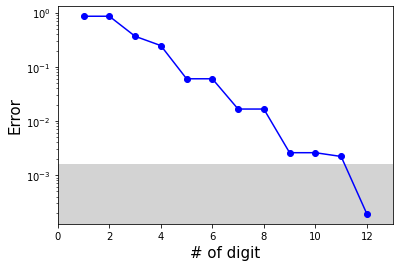

In [7]:
result_array = np.array(result_list)
plt.xlabel("# of digit", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.semilogy(result_array[:,0], np.abs(result_array[:,1] - e_trotter), "bo-")
plt.xlim(0,13)
plt.fill_between([0,13], 1.6e-3, color = "lightgrey")